# Community Detection

Author : _Emre Okcular_

In [41]:
import networkx as nx
import numpy as np
from networkx.algorithms import approximation
from networkx.algorithms import reciprocity
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import combinations, groupby
from node2vec import Node2Vec
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import statistics

%matplotlib inline

In [37]:
def node2vec_from_graph(G, D):
    node2vec = Node2Vec(G, dimensions=D)
    model = node2vec.fit()
    embeddings = model.wv.vectors
    return embeddings

In [24]:
def get_circle_labels(G,circles):
    circle_labels = []
    for node in G.nodes():
        is_added = False
        for i,li in enumerate(list(circles.values())):
            if node in li and not is_added:
                circle_labels.append(i)
                is_added = True
        if not is_added:
            circle_labels.append(-1)
    return circle_labels

In [25]:
def get_community_labels(G, circles):
    community_labels = []
    for node in G.nodes():
        is_added = False
        for i,li in enumerate(lab):
            if node in li and not is_added:
                community_labels.append(i)
                is_added = True
        if not is_added:
            community_labels.append(-1)
    return community_labels

In [26]:
def colorize_nodes(labels, G):
    final = [(0,0,0) for i in range(len(G.nodes()))]
    colors = [(np.random.random(1)[0],np.random.random(1)[0],np.random.random(1)[0]) for i in range(len(labels))]
    
    for j,n in enumerate(G.nodes()):
        for i,label in enumerate(labels):
            if n in label:
                final[j]=colors[i]
    return final

In [27]:
def explore_and_summarize_network(edgelist, vertices, subgraph, directed=False, circles=None):
    """
    Concisely summarizes any induced subgraph of the input network
    """
    G = nx.Graph()
    if subgraph is not None:
        induced_edges = [ edge for edge in edgelist if ((edge[0] in subgraph) and (edge[1] in subgraph))]
        G.add_nodes_from(subgraph)
        G.add_edges_from(induced_edges, nodetype=int)
    else :
        G.add_nodes_from(vertices)
        G.add_edges_from(edgelist, nodetype=int)
    G = list(G.subgraph(c) for c in nx.connected_components(G))[0]
    sum_list, labels, modularity, isolates = local_summaries_v2(G)
    # (a)
    nx.draw(G,pos=nx.fruchterman_reingold_layout(G),node_color=colorize_nodes(labels, G),
        node_size=20,
        edge_color="gray",
        width=0.5, cmap=plt.cm.Blues)
    plt.show()
    if circles:
        nx.draw(G,pos=nx.fruchterman_reingold_layout(G),node_color=colorize_nodes([set(item) for item in circles.values()],G),
        node_size=20,
        edge_color="gray",
        width=0.5, cmap=plt.cm.Blues)


    # (b)
    if directed:
        in_degree_sequence = [item[-2] for item in local_summaries_v2(G)[0]]
        in_degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(in_degree_counts.keys(), in_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('In Degrees')
        ax.set_title(r'Histogram of in_degrees')
        fig.tight_layout()
        plt.show()
        
        out_degree_sequence = [item[-1] for item in local_summaries_v2(G)[0]]
        out_degree_counts = Counter(out_degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(out_degree_counts.keys(), out_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of out_degrees')
        fig.tight_layout()
        plt.show()
        
        reciprocity_sequence = [item[-1] for item in local_summaries_v2(G)[0]]
        reciprocity_counts = Counter(reciprocity_sequence)
        fig, ax = plt.subplots()
        ax.bar(reciprocity_counts.keys(), reciprocity_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of Reciprocity')
        fig.tight_layout()
        plt.show() 
    else:
        degree_sequence = [item[-1] for item in local_summaries_v2(G)[0]]
        degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(degree_counts.keys(), degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('Degrees')
        ax.set_title(r'Histogram of degrees')
        fig.tight_layout()
        plt.show() 
    # (c)
    betweenness_centrality = [item[0] for item in local_summaries_v2(G)[0]]
    fig1, ax1 = plt.subplots()
    ax1.hist(betweenness_centrality)
    ax1.set_xlabel('Nodes')
    ax1.set_ylabel('Betweenness Centrality')
    ax1.set_title(r'Histogram of Betweenness Centrality')
    fig1.tight_layout()
    plt.show()
    # (d)
    eigenvector_centrality = [item[1] for item in local_summaries_v2(G)[0]]
    fig2, ax2 = plt.subplots()
    ax2.hist(eigenvector_centrality)
    ax2.set_xlabel('Nodes')
    ax2.set_ylabel('Eigenvector Centrality')
    ax2.set_title(r'Histogram of Eigenvector Centrality')
    fig2.tight_layout()
    plt.show()
    # Print Global Summaries
    global_summaries(G)
    print("Modularity : ", modularity)
    return labels

In [28]:
def local_summaries_v2(G, directed=False):
    
    betweenness_centrality = nx.centrality.betweenness_centrality(G)
    max_betweenness_centrality_node = max(betweenness_centrality, key=betweenness_centrality.get)
    eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
    max_eigenvector_centrality = max(eigenvector_centrality, key=eigenvector_centrality.get)
    closeness_centrality = nx.centrality.closeness_centrality(G)
    max_closeness_centrality = max(closeness_centrality, key=closeness_centrality.get)
    
    if directed:
        in_degrees = [G.in_degree(n) for n in G.nodes]
        in_degree_dict= {n:G.degree(n) for n in G.nodes}
        max_in_degree = max(max_in_degree, key=max_in_degree.get)
        out_degrees = [G.in_degree(n) for n in G.nodes]
        out_degree_dict= {n:G.degree(n) for n in G.nodes}
        max_out_degree = max(out_degree_dict, key=out_degree_dict.get)
        reciprocity = nx.algorithms.reciprocity(G)
        mean_reciprocity = [value for key,value in nx.algorithms.reciprocity(G)].mean()
        return zip(betweenness_centrality.values(), 
                   eigenvector_centrality.values(), 
                   closeness_centrality.values(), 
                   in_degrees, 
                   out_degrees,
                   reciprocity,
                   nx.clustering(G)), max_betweenness_centrality_node, max_eigenvector_centrality, max_closeness_centrality, max_in_degree, max_out_degree, mean_reciprocity, nx.algorithms.isolate.number_of_isolates(G)
    else:
        degrees =[G.degree(n) for n in G.nodes]
        partitions = list(nx.algorithms.community.centrality.girvan_newman(G))
        mod_scores = [nx.community.quality.modularity(G, partition) for partition in partitions]
        maximum_modularity_score = max(mod_scores)
        best_partition = partitions[mod_scores.index(maximum_modularity_score)]
        return zip(betweenness_centrality.values(), 
                   eigenvector_centrality.values(), 
                   closeness_centrality.values(), 
                   degrees,
                   nx.clustering(G)), best_partition,  maximum_modularity_score ,nx.algorithms.isolate.number_of_isolates(G)
        
    

In [29]:
def global_summaries(G):
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
    except:
        diameter = "Found infinite path length because the graph is not connected !"
    clustering_coefficient = nx.algorithms.approximation.clustering_coefficient.average_clustering(G)
    number_of_nodes = G.number_of_edges()
    number_of_edges = G.number_of_nodes()
    number_of_connected_components = nx.number_connected_components(G)
    largest_connected_component = max([ len(i) for i in list(nx.connected_components(G))])
    print("##### Global Summaries #####")
    print("Diameter : ",diameter)
    print("Number of Nodes : ",number_of_nodes)
    print("Number of Edges : ",number_of_edges)
    print("Number of Connected Components : ",number_of_connected_components)
    print("Size of the Largest Connected Compopnent : ",largest_connected_component)

In [30]:
def read_circles(file_path):
    with open(file_path) as f :
        content = f.readlines()
        content = [line.replace("\n","") for line in content]
        content = [line.split("\t") for line in content]
    return {circle[0]:list(map(int,circle[1:])) for circle in content} # Convert nodes to int and add to dict.

#### Random Graph generated for validating

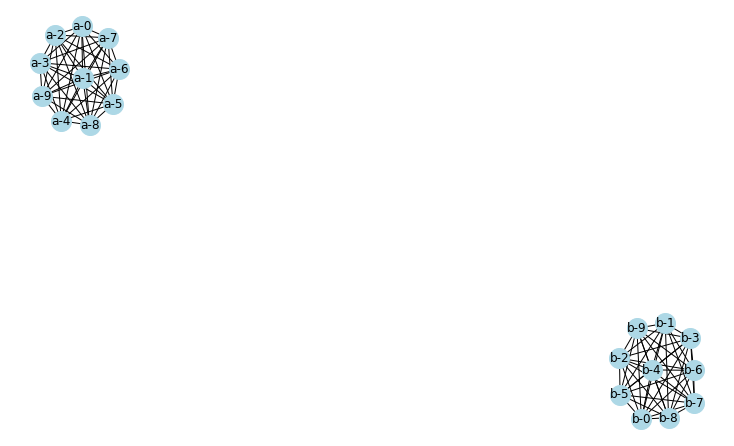

In [16]:
G_random1 = nx.complete_graph(10)
G_random2 = nx.complete_graph(10)

G_combined = nx.union(G_random1, G_random2, rename=('a-', 'b-'))


plt.figure(figsize=(10,6))

nx.draw(G_combined, node_color='lightblue', 
        with_labels=True, 
        node_size=400)

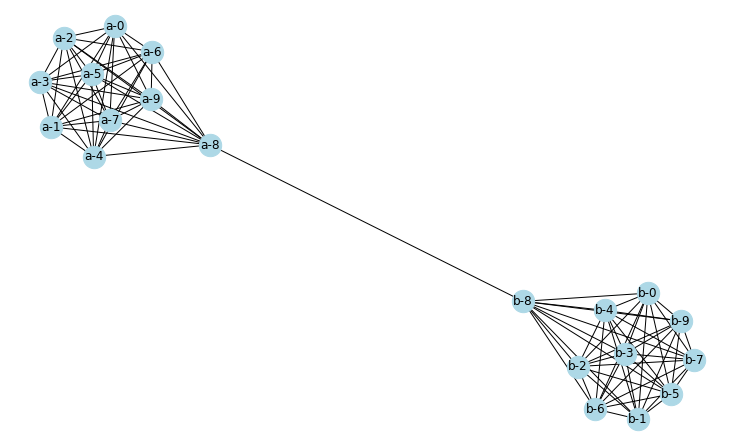

In [17]:
G_combined.add_edge('b-8', 'a-8')

plt.figure(figsize=(10,6))

nx.draw(G_combined, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

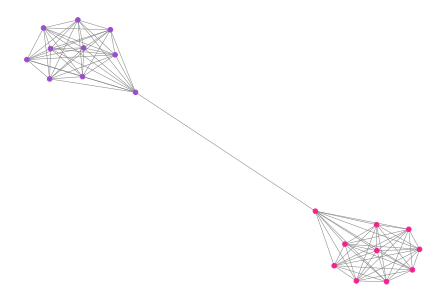

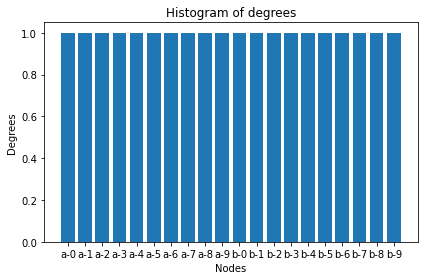

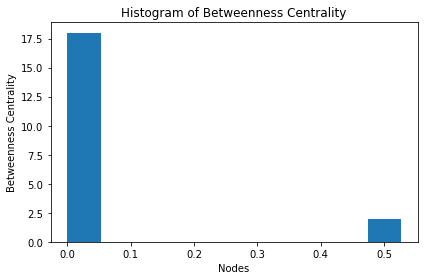

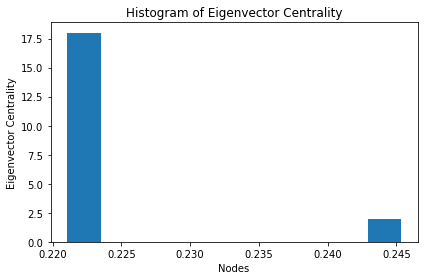

##### Global Summaries #####
Diameter :  3
Number of Nodes :  91
Number of Edges :  20
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  20
Modularity :  0.48901098901098905


In [18]:
lab_small = explore_and_summarize_network(edgelist = G_combined.edges(), vertices=G_combined.nodes(), subgraph=None)

**NOTE: I tried to run my function with Node 107 several times. It took more than 3 hours to run and then my notebook shut down. Therefore I could only use Node 0.**

In [19]:
G = nx.read_edgelist('facebook/0.edges', nodetype=int)

In [20]:
circles = read_circles("facebook/0.circles")

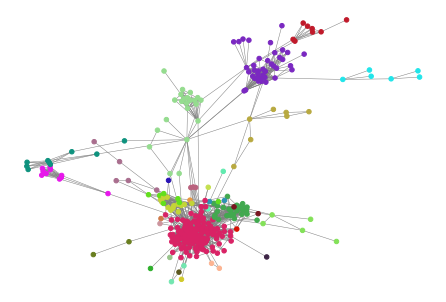

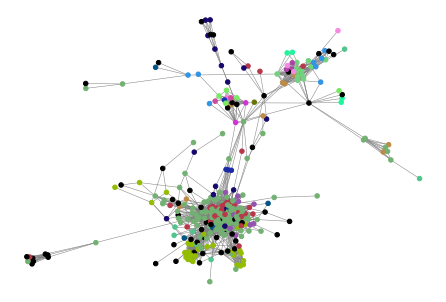

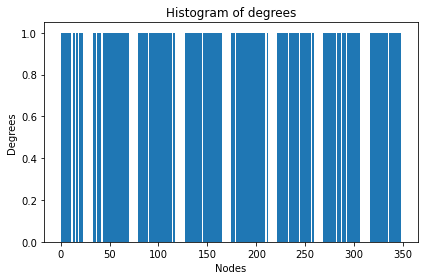

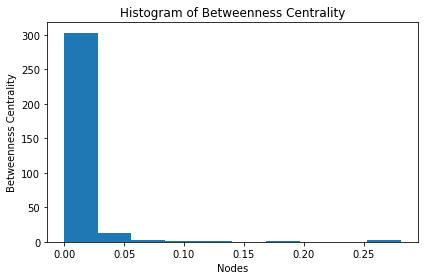

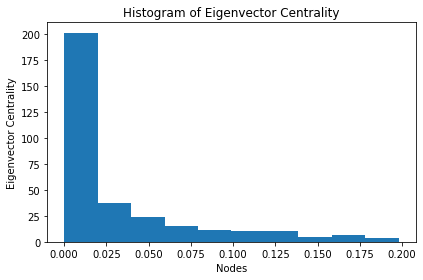

##### Global Summaries #####
Diameter :  11
Number of Nodes :  2514
Number of Edges :  324
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  324
Modularity :  0.4139775886697185


In [21]:
lab = explore_and_summarize_network(edgelist = G.edges(), vertices=G.nodes(), subgraph=None, circles=circles)

Below you can see the barchart of 5 largest communities.

In [128]:
maximums = [len(i) for i in lab]

In [127]:
li = []
for i,partition in enumerate(lab):
    te = [0 for i in circles]
    for node in partition:
        for i,k in enumerate(circles.items()):
            print(k[1])
            if node in k[1]:
                te[i] += 1
    li.append(te)

[71, 215, 54, 61, 298, 229, 81, 253, 193, 97, 264, 29, 132, 110, 163, 259, 183, 334, 245, 222]
[173]
[155, 99, 327, 140, 116, 147, 144, 150, 270]
[51, 83, 237]
[125, 344, 295, 257, 55, 122, 223, 59, 268, 280, 84, 156, 258, 236, 250, 239, 69]
[23]
[337, 289, 93, 17, 111, 52, 137, 343, 192, 35, 326, 310, 214, 32, 115, 321, 209, 312, 41, 20]
[225, 46]
[282]
[336, 204, 74, 206, 292, 146, 154, 164, 279, 73]
[42, 14, 216, 2]
[324, 265, 54, 161, 298, 76, 165, 199, 203, 13, 66, 113, 97, 252, 313, 238, 158, 240, 331, 332, 134, 218, 118, 235, 311, 151, 308, 212, 70, 211]
[278]
[138, 131, 68, 143, 86]
[175, 227]
[108, 208, 251, 125, 325, 176, 133, 276, 198, 271, 288, 316, 96, 246, 347, 121, 7, 3, 170, 323, 56, 338, 23, 109, 141, 67, 345, 55, 114, 122, 50, 304, 318, 65, 15, 45, 317, 322, 26, 31, 168, 124, 285, 255, 129, 40, 172, 274, 95, 207, 128, 339, 233, 1, 294, 280, 224, 269, 256, 60, 328, 189, 146, 77, 196, 64, 286, 89, 22, 39, 190, 281, 117, 38, 213, 135, 197, 291, 21, 315, 261, 47, 36, 186,

In [154]:
lo = list(map(list, zip(*emre)))

In [193]:
label_list = list(circles.keys())
top_5 = li[0] , li[4], li[1] , li[2] , li[3]
data = np.array(top_5)

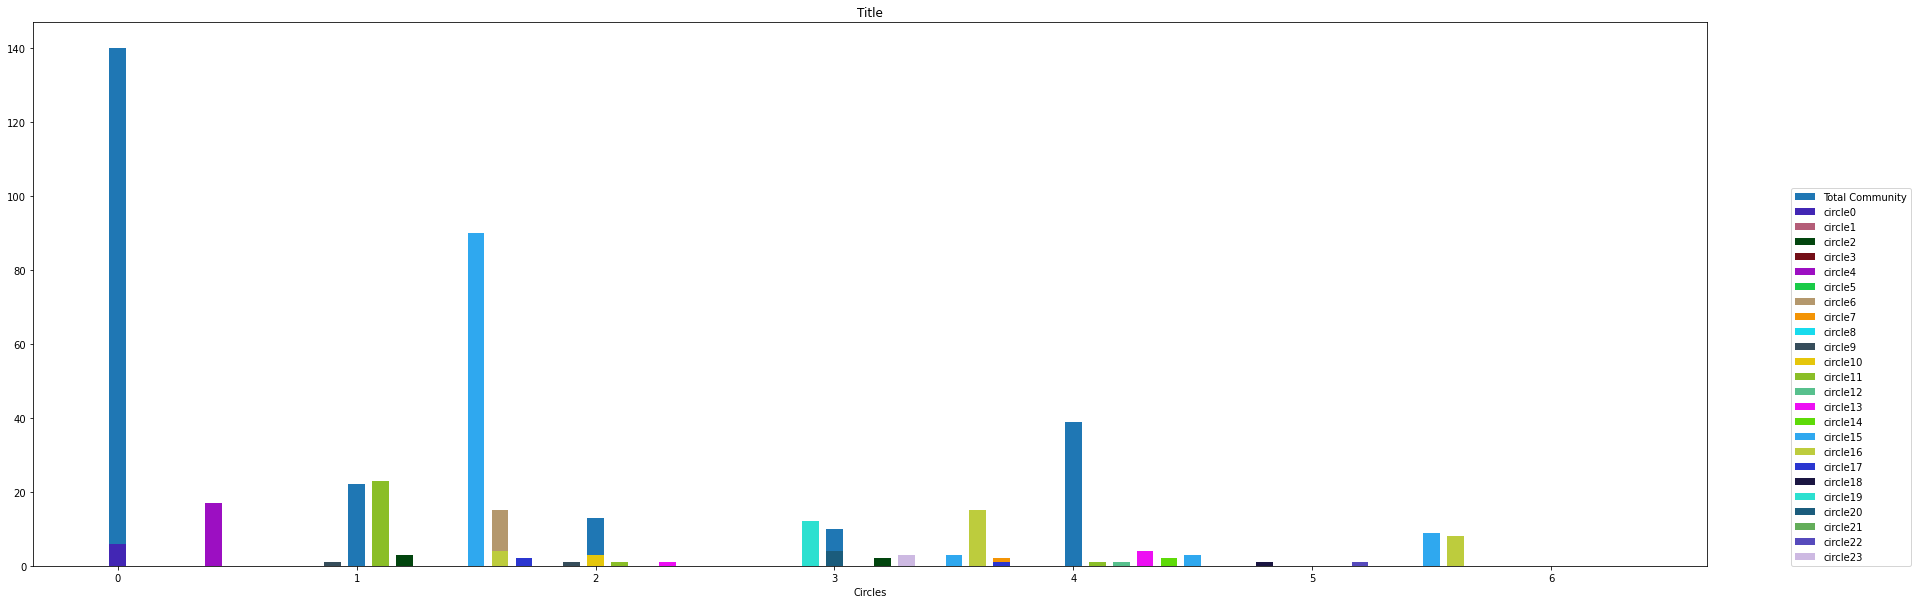

In [213]:
ax = plt.subplot(111)
plt.rcParams["figure.figsize"] = (30,5)

x = [0,4,1,2,3]
y = [140, 39, 22, 13, 10]
ax.bar(x,y,width=0.07,label="Total Community")
x = np.arange(len(data))

for i in range(len(top_5[0])):
    ax.bar(x+(i*.1), data[:,i], width=0.07, color=(np.random.random(1)[0],np.random.random(1)[0],np.random.random(1)[0]), align='center',label=label_list[i])

ax.set_xlabel('Circles')
ax.set_title('Title')
ax.legend(loc=(1.05,0))
plt.show()

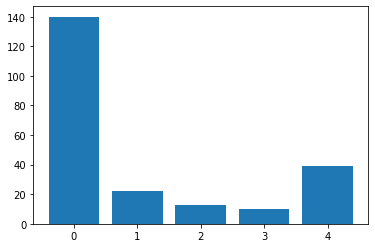

In [53]:
x = [0,4,1,2,3]
y = [140, 39, 22, 13, 10]
plt.bar(x,y)


plt.show()

In [231]:
G = nx.read_edgelist('facebook/0.edges', nodetype=int)

In [232]:
circles = read_circles("facebook/0.circles")

In [233]:
adjusted_rand_score(get_community_labels(G, circles), get_circle_labels(G, circles))

0.2440832661519791

In [234]:
G = nx.read_edgelist('facebook/107.edges', nodetype=int)

In [236]:
circles = read_circles("facebook/107.circles")

In [237]:
adjusted_rand_score(get_community_labels(G, circles), get_circle_labels(G, circles))

0.0010857311623432766

Based on these results,the community detection identify social circles on Facebook poorly.

## Node2Vec

In [221]:
embeddings = node2vec_from_graph(G_combined,10)

Generating walks (CPU: 1):  30%|███       | 3/10 [00:00<00:00, 25.46it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 16.34it/s]


In [224]:
embeddings[0:3] # sample 3 example

array([[ 3.0854082e-01,  2.6959461e-01,  5.6640260e-02,  1.2577164e-01,
         2.9893371e-04, -1.9613087e-02,  1.0850565e+00,  6.4780921e-01,
        -6.3928491e-01,  2.4207579e-01],
       [ 4.9282536e-01,  3.0694455e-01, -1.3824855e-01,  1.2699915e-01,
         2.2532191e-02,  3.9665021e-02,  1.1947058e+00,  7.4149370e-01,
        -7.4095601e-01,  2.7809593e-01],
       [ 4.0901604e-01,  4.1216984e-01,  2.8613407e-02,  6.6482395e-02,
         1.0756147e-01, -2.8668731e-02,  1.1575453e+00,  7.7264446e-01,
        -7.3118126e-01,  3.1342053e-01]], dtype=float32)

### For Node 0

In [225]:
G = nx.read_edgelist('facebook/0.edges', nodetype=int)

In [226]:
circles = read_circles("facebook/0.circles")

In [227]:
embeddings = node2vec_from_graph(G,30)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


In [228]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)

In [229]:
kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

In [230]:
kmeans.cluster_centers_

array([[-0.31516004, -0.5860579 , -0.14402421, -0.6441936 ,  0.11423245,
         0.10111803, -0.14444494, -0.01485963,  0.0646882 ,  0.16028976,
        -0.0907208 , -0.2121817 ,  0.04688997, -0.34263247, -0.37898302,
        -0.07648672, -0.54261464,  0.14451672, -0.8012056 , -0.01545094,
        -0.3252318 , -0.13297626,  0.16222109,  0.19854078,  0.01350708,
         0.20496371,  0.52075577, -0.08938148, -0.23947671, -0.3382421 ],
       [-0.28250146, -1.1853251 , -0.6914925 , -0.20492601,  0.3984131 ,
         0.75050783,  0.9729067 , -0.03989834,  0.38145137,  0.36189365,
        -0.21976364, -0.04714028, -0.17187129, -0.40180156, -0.08695784,
         0.5783661 , -0.19366951,  0.1294069 , -0.1339925 , -0.36079174,
         0.32717296, -0.5165937 ,  0.6715609 , -0.14924335, -0.75183904,
        -0.6255285 ,  1.100609  , -0.41542774, -0.30665377, -0.38803434]],
      dtype=float32)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, get_circle_labels(G, circles), test_size=0.33, random_state=42)

In [44]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
ypred = rf.predict(X_test)
score = f1_score(y_test,ypred,average = "micro")
print("F1 Score : ",score)

F1 Score :  0.34545454545454546


### For Node 107

In [45]:
G = nx.read_edgelist('facebook/107.edges', nodetype=int)

In [46]:
circles = read_circles("facebook/107.circles")

In [47]:
embeddings = node2vec_from_graph(G,30)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:37<00:00,  3.74s/it]


In [48]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, get_circle_labels(G, circles), test_size=0.33, random_state=42)

In [49]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
ypred = rf.predict(X_test)
score = f1_score(y_test,ypred,average = "micro")
print("F1 Score : ",score)

F1 Score :  0.5029239766081871


---